In [1]:
import xarray as xr
import numpy as np
import intake

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='ocean'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

['2D_daily_avg', '3D_daily_avg', '3D_monthly_avg_elems']


In [2]:
ds = cat_data['3D_daily_avg'].to_dask()
ds

<xarray.Dataset> Size: 339TB
Dimensions:     (time: 23741, lev: 69, ncells: 7402886, ncells_2: 14741520,
                 lev_2: 70, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 190kB 1950-01-01 1950-01-02 ... 2014-12-31
  * lev         (lev) float64 552B 2.5 7.5 12.5 ... 5.825e+03 6.175e+03
  * lev_2       (lev_2) int32 280B 0 5 10 15 20 25 ... 5150 5400 5650 6000 6350
Dimensions without coordinates: ncells, ncells_2, bnds
Data variables:
    avg_so      (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_thetao  (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_uoe     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_von     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_wo      (time, lev_2, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    lev_bnds    (time, lev, bnds) float64 26MB dask.array<chunksize=(23741, 69, 2), meta=np.ndarray>
Attributes: (12/35)
    CDI:                   Climate Data Interface version 2.4.0 (https://mpim...
    Conventions:           CF-1.7 CMIP-6.2
    number_of_grid_used:   9
    NCO:                   netCDF Operators version 5.0.6 (Homepage = http://...
    CDO:                   Climate Data Operators version 2.4.0 (https://mpim...
    activity_id:           HighResMIP
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [3]:
grid = xr.open_dataset('/work/ab0995/a270088/meshes/NG5/fesom.mesh.diag.nc')

sh: getfattr: command not found


In [4]:
grid

<xarray.Dataset> Size: 7GB
Dimensions:            (elem: 14741520, nod2: 7402886, nz: 70, n3: 3, n2: 2,
                        N: 8, edg_n: 22144811, n4: 4, nz1: 69)
Coordinates:
  * nz                 (nz) float64 560B 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 552B -2.5 -7.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: elem, nod2, n3, n2, N, edg_n, n4
Data variables: (12/19)
    elem_area          (elem) float64 118MB ...
    nlevels_nod2D      (nod2) int32 30MB ...
    nlevels            (elem) int32 59MB ...
    nod_in_elem2D_num  (nod2) int32 30MB ...
    nod_part           (nod2) int32 30MB ...
    elem_part          (elem) int32 59MB ...
    ...                 ...
    nod_in_elem2D      (N, nod2) int32 237MB ...
    edges              (n2, edg_n) int32 177MB ...
    edge_tri           (n2, edg_n) int32 177MB ...
    edge_cross_dxdy    (n4, edg_n) float64 709MB ...
    gradient_sca_x     (elem, n3) float64 354MB ...
    gradient_sca_y     (elem, n3) float64 354MB ...

In [5]:
lon = grid.lon.values
lat = grid.lat.values
data_sample_3d = ds['avg_thetao'][0,:,:]

In [6]:
nod_area = grid['nod_area']
nod_area = nod_area.rename({'nod2': 'ncells', 'nz':'lev'})

In [7]:
nod_area_69 = nod_area.isel(lev=slice(0, data_sample_3d.sizes['lev']))
nod_area_same = xr.DataArray(
    nod_area_69.values,          # (69, 7402886)
    dims=data_sample_3d.dims,    # ('lev', 'ncells')
    coords=data_sample_3d.coords,
    name="nod_area",
)

In [8]:
data_sample = ds['avg_thetao'][0,0,:]

### Spatial mean the wrong way

In [9]:
data_sample.mean(dim='ncells').values

array(12.261564, dtype=float32)

### Spatial mean the right way (weighted mean)

In [10]:
((data_sample*nod_area_same[0,:]).sum(dim='ncells')/nod_area_same[0,:].sum(dim='ncells')).values

array(18.08760202)

### Vertical profile

In [11]:
weighted = (data_sample_3d * nod_area_same).sum(dim='ncells')/nod_area_same.sum(dim='ncells')

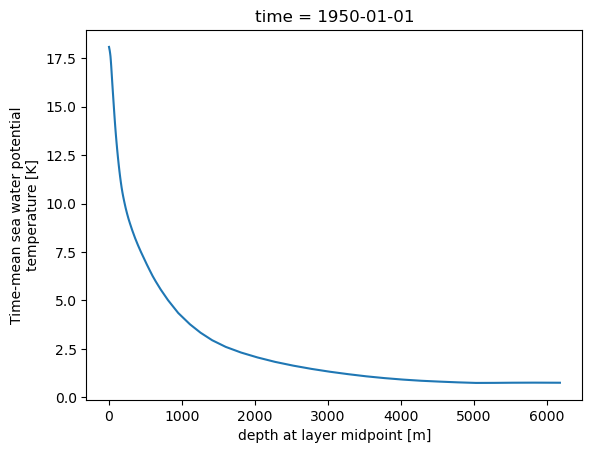

In [12]:
weighted.plot()

Text(0, 0.5, 'Depth [m]')

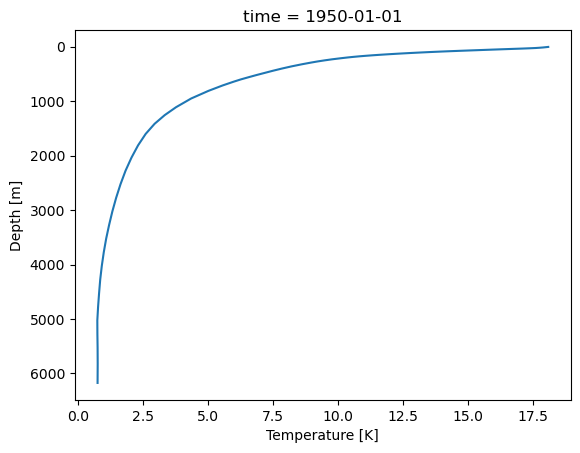

In [13]:
lines = weighted.plot(y='lev')  # x = data (temperature), y = lev (depth)
ax = lines[0].axes             # get the Axes from the Line2D

ax.invert_yaxis()              # depth increasing downward
ax.set_xlabel("Temperature [K]")  # or °C if you convert
ax.set_ylabel("Depth [m]")

In [14]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=20, threads_per_worker=1, memory_limit='10GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32897,Workers: 0
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43831,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/38797/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:38725,


In [18]:
ds = cat_data['3D_daily_avg'](chunks="auto").to_dask()
ds

<xarray.Dataset> Size: 339TB
Dimensions:     (time: 23741, lev: 69, ncells: 7402886, ncells_2: 14741520,
                 lev_2: 70, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 190kB 1950-01-01 1950-01-02 ... 2014-12-31
  * lev         (lev) float64 552B 2.5 7.5 12.5 ... 5.825e+03 6.175e+03
  * lev_2       (lev_2) int32 280B 0 5 10 15 20 25 ... 5150 5400 5650 6000 6350
Dimensions without coordinates: ncells, ncells_2, bnds
Data variables:
    avg_so      (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_thetao  (time, lev, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    avg_uoe     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_von     (time, lev, ncells_2) float32 97TB dask.array<chunksize=(1, 1, 14741520), meta=np.ndarray>
    avg_wo      (time, lev_2, ncells) float32 49TB dask.array<chunksize=(2, 2, 7402886), meta=np.ndarray>
    lev_bnds    (time, lev, bnds) float64 26MB dask.array<chunksize=(23741, 69, 2), meta=np.ndarray>
Attributes: (12/35)
    CDI:                   Climate Data Interface version 2.4.0 (https://mpim...
    Conventions:           CF-1.7 CMIP-6.2
    number_of_grid_used:   9
    NCO:                   netCDF Operators version 5.0.6 (Homepage = http://...
    CDO:                   Climate Data Operators version 2.4.0 (https://mpim...
    activity_id:           HighResMIP
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [19]:
time_period = ds['avg_thetao'].sel(time=slice('1950-01', '1950-02'))

In [20]:
time_period

<xarray.DataArray 'avg_thetao' (time: 59, lev: 69, ncells: 7402886)> Size: 121GB
dask.array<getitem, shape=(59, 69, 7402886), dtype=float32, chunksize=(2, 2, 7402886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 472B 1950-01-01 1950-01-02 ... 1950-02-28
  * lev      (lev) float64 552B 2.5 7.5 12.5 ... 5.525e+03 5.825e+03 6.175e+03
Dimensions without coordinates: ncells
Attributes:
    long_name:                    Time-mean sea water potential temperature
    units:                        K
    param:                        18.4.10
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  7

In [21]:
time_period*nod_area_same

<xarray.DataArray (time: 59, lev: 69, ncells: 7402886)> Size: 241GB
dask.array<mul, shape=(59, 69, 7402886), dtype=float64, chunksize=(2, 2, 7402886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 472B 1950-01-01 1950-01-02 ... 1950-02-28
  * lev      (lev) float64 552B 2.5 7.5 12.5 ... 5.525e+03 5.825e+03 6.175e+03
Dimensions without coordinates: ncells
Attributes:
    long_name:                    Time-mean sea water potential temperature
    units:                        K
    param:                        18.4.10
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  7

In [23]:
temp_mean = ((time_period*nod_area_same).sum(dim='ncells')/nod_area_same.sum(dim='ncells'))

In [24]:
%%time
temp_mean=temp_mean.compute()

/work/ab0995/a270088/mambaforge/envs/iccp/lib/python3.11/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 3.81 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 14.4 s, sys: 5.31 s, total: 19.7 s
Wall time: 49 s


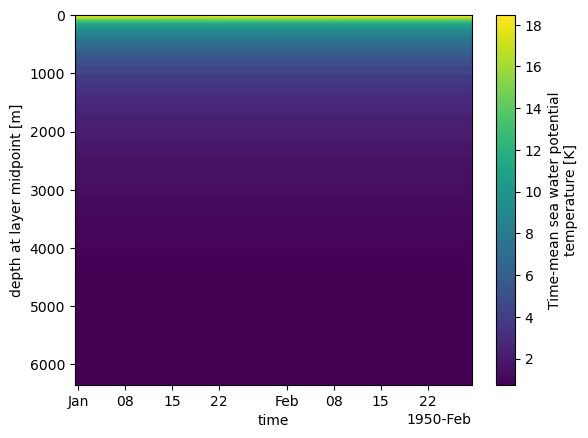

In [32]:
qm = temp_mean.plot(y='lev')   # qm is a QuadMesh
ax = qm.axes                    # extract the Axes
ax.invert_yaxis()              # depth increases downward